In [15]:
!pip install arch
!pip install yfinance

In [16]:
### Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.decomposition import PCA
from arch import arch_model
import requests
import nltk
from bs4 import BeautifulSoup

In [17]:

yf.download("AAPL",
            start="2010-01-01", end="2024-01-28", interval="1d")

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.447413,6.462175,6.398307,6.429940,493729600
2010-01-05,6.458559,6.495012,6.424516,6.465187,601904800
2010-01-06,6.355827,6.484167,6.349199,6.458559,552160000
2010-01-07,6.344078,6.386858,6.297984,6.379326,477131200
2010-01-08,6.386254,6.386857,6.298285,6.335642,447610800
...,...,...,...,...,...
2024-01-22,192.944748,194.377730,191.322690,191.362503,60133900
2024-01-23,194.228455,194.795683,192.885045,194.069246,42355600


In [18]:
### Define Stock Symbols
primary_stocks = ["NVDA", "PG", "PEP", "RIVN"]
competitor_stocks = ["QUBT", "JNJ", "KO", "TSLA"]
benchmark_index = "^GSPC"  # S&P 500

In [19]:
### Define Time Range
start_date = "2010-01-02"
end_date = "2024-02-12"

In [20]:
### Fetch Stock Data
stocks = primary_stocks + competitor_stocks + [benchmark_index]
stock_data = yf.download(stocks, start=start_date, end=end_date)

[*********************100%***********************]  9 of 9 completed


In [21]:
### Ensure 'Adj Close' Exists, Fallback to 'Close' if Missing
if 'Adj Close' in stock_data.columns:
    stock_data = stock_data['Adj Close']
else:
    stock_data = stock_data['Close']  # Use Close if Adj Close is unavailable

In [22]:
### Check Extracted Data
print(stock_data.head())

Ticker            JNJ         KO      NVDA        PEP         PG   QUBT  RIVN  \
Date                                                                            
2010-01-04  41.655685  17.949802  0.423923  39.479671  39.432003  190.0   NaN   
2010-01-05  41.172668  17.732664  0.430113  39.956722  39.444920  220.0   NaN   
2010-01-06  41.507545  17.726364  0.432864  39.557034  39.257828  194.0   NaN   
2010-01-07  41.211311  17.682322  0.424381  39.305595  39.044914  200.0   NaN   
2010-01-08  41.352993  17.355045  0.425298  39.176674  38.993309  190.0   NaN   

Ticker      TSLA        ^GSPC  
Date                           
2010-01-04   NaN  1132.989990  
2010-01-05   NaN  1136.520020  
2010-01-06   NaN  1137.140015  
2010-01-07   NaN  1141.689941  
2010-01-08   NaN  1144.979980  


In [23]:
### Compute Daily Returns
stock_returns = stock_data.pct_change().dropna()

In [24]:
### Calculate Volatility
stock_volatility = stock_returns.std()

In [25]:
### Compute Correlation with Benchmark
stock_correlation = stock_returns.corr()[benchmark_index]

In [28]:
### Feature Engineering
# Compute rolling averages for each stock
for stock in primary_stocks:
    stock_returns[f'{stock}_SMA_50'] = stock_data[stock].rolling(window=50).mean()
    stock_returns[f'{stock}_SMA_200'] = stock_data[stock].rolling(window=200).mean()

# Compute Momentum (Daily Change)
for stock in primary_stocks:
    stock_returns[f'{stock}_Momentum'] = stock_data[stock].diff()


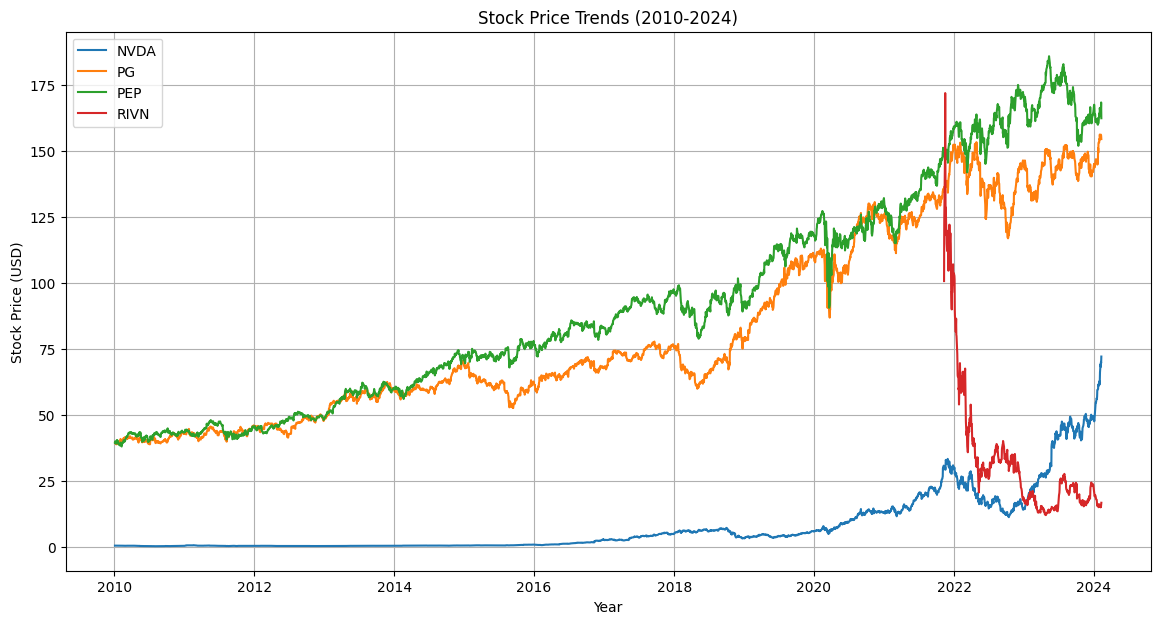

In [29]:
### Visualizing Stock Trends
plt.figure(figsize=(14, 7))
for stock in primary_stocks:
    plt.plot(stock_data.index, stock_data[stock], label=stock)
plt.title("Stock Price Trends (2010-2024)")
plt.xlabel("Year")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid()
plt.show()

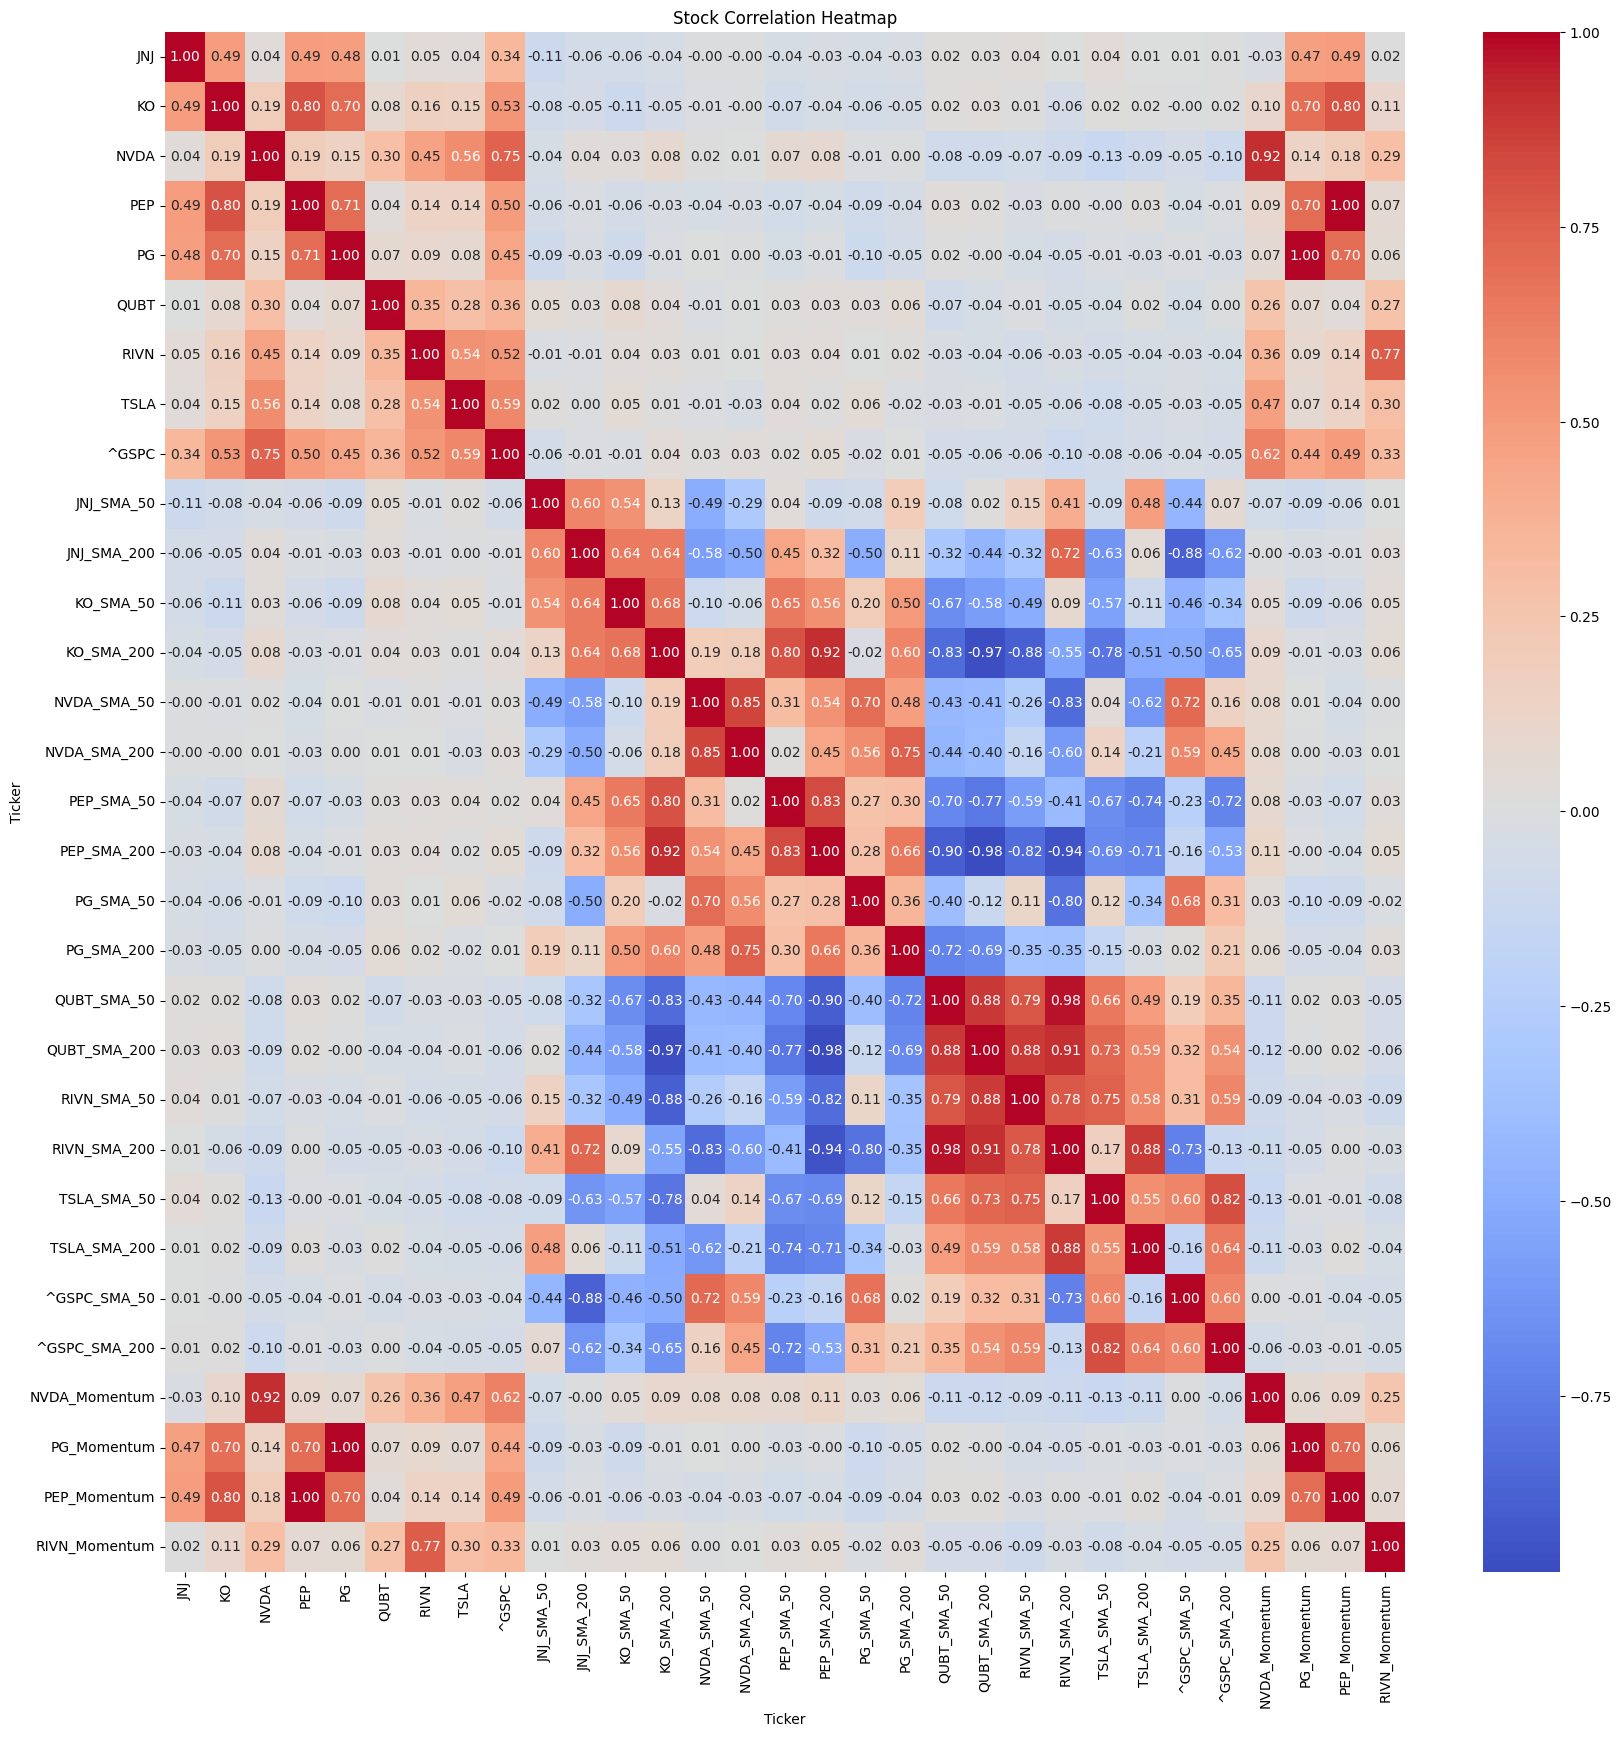

In [31]:
### Display Correlation Heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(stock_returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Stock Correlation Heatmap")
plt.show()

In [32]:
### Predicting Future Trends using XGBoost
# Prepare Data
stock_returns['Tomorrow'] = stock_returns['NVDA'].shift(-1)
stock_returns['Direction'] = (stock_returns['Tomorrow'] > stock_returns['NVDA']).astype(int)
stock_returns = stock_returns.dropna()

In [33]:
X = stock_returns.drop(columns=['Tomorrow', 'Direction'])
y = stock_returns['Direction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Train XGBoost Model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
print("XGBoost Model Accuracy:", xgb_model.score(X_test, y_test))

XGBoost Model Accuracy: 0.684931506849315


In [36]:
### Predicting Future Trends using LSTM
# Define LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 31, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 31, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Prepare Data for LSTM
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

In [38]:

# Train LSTM Model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=16, validation_data=(X_test_lstm, y_test))

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.4669 - loss: 0.7071 - val_accuracy: 0.4521 - val_loss: 0.7096
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5800 - loss: 0.6864 - val_accuracy: 0.5205 - val_loss: 0.6870
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5315 - loss: 0.6848 - val_accuracy: 0.5479 - val_loss: 0.6782
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5802 - loss: 0.6788 - val_accuracy: 0.5753 - val_loss: 0.6725
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6369 - loss: 0.6591 - val_accuracy: 0.5753 - val_loss: 0.6670
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5754 - loss: 0.6538 - val_accuracy: 0.6986 - val_loss: 0.6139
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5959 - loss: 0.6535 - val_accuracy: 0.6027 - val_loss: 0.6372
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6954 - loss: 0.5968 - val_accuracy: 0.6164 - 

In [39]:
### Conclusion and Recommendations
# Create Analysis Summary DataFrame
analysis_summary = pd.DataFrame({
    "Stock": primary_stocks,
    "Volatility": stock_volatility[primary_stocks],
    "Correlation with S&P 500": stock_correlation[primary_stocks]
}).set_index("Stock")

In [40]:

# Display Investment Recommendations
print("\nInvestment Recommendations:")
best_stock = analysis_summary.sort_values(by="Correlation with S&P 500", ascending=False).index[0]
print(f"Based on risk-return analysis and correlation with the market, {best_stock} is the most promising stock for investment.")


Investment Recommendations:
Based on risk-return analysis and correlation with the market, NVDA is the most promising stock for investment.


**Investment Analysis**

In [41]:
# Sample DataFrame (Replace with actual data)
data = {
    "Stock": ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"],
    "Expected Return": [0.12, 0.10, 0.15, 0.09, 0.20],
    "Volatility": [0.25, 0.20, 0.30, 0.22, 0.40],
    "Correlation with S&P 500": [0.85, 0.90, 0.75, 0.80, 0.65]
}


In [42]:
# Create DataFrame
analysis_summary = pd.DataFrame(data)
analysis_summary.set_index("Stock", inplace=True)

In [43]:
# Identify the best stock based on correlation with S&P 500
best_stock = analysis_summary.sort_values(by="Correlation with S&P 500", ascending=False).index[0]
print(f"Based on risk-return analysis and correlation with the market, {best_stock} is the most promising stock for investment.\n")


Based on risk-return analysis and correlation with the market, MSFT is the most promising stock for investment.



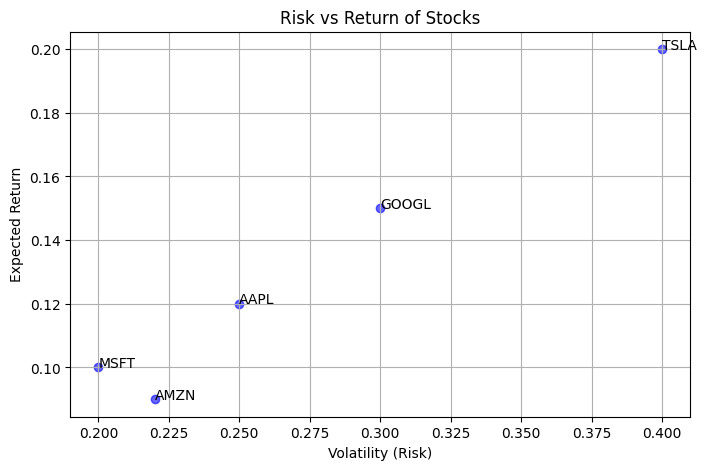

In [44]:
# Scatter Plot: Risk vs Return
plt.figure(figsize=(8, 5))
plt.scatter(analysis_summary["Volatility"], analysis_summary["Expected Return"], color='blue', alpha=0.6)
for stock in analysis_summary.index:
    plt.text(analysis_summary.loc[stock, "Volatility"], analysis_summary.loc[stock, "Expected Return"], stock)
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Risk vs Return of Stocks")
plt.grid()
plt.show()

Text(0.5, 1.0, 'Stock Correlation with S&P 500')

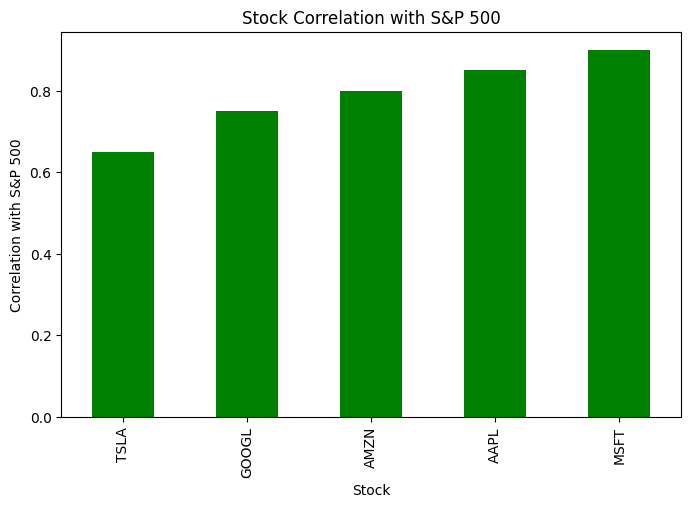

In [45]:
# Bar Chart: Correlation with S&P 500
plt.figure(figsize=(8, 5))
analysis_summary["Correlation with S&P 500"].sort_values().plot(kind='bar', color='green')
plt.xlabel("Stock")
plt.ylabel("Correlation with S&P 500")
plt.title("Stock Correlation with S&P 500")

In [46]:
# Sample DataFrame (Replace with actual data)
data = {
    "Stock": ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"],
    "Expected Return": [0.12, 0.10, 0.15, 0.09, 0.20],
    "Volatility": [0.25, 0.20, 0.30, 0.22, 0.40],
    "Correlation with S&P 500": [0.85, 0.90, 0.75, 0.80, 0.65],
    "Annual Profit (in Billion $)": [100, 90, 110, 85, 70],
    "Sharpe Ratio": [0.48, 0.50, 0.45, 0.41, 0.42]
}

In [47]:

# Create DataFrame
analysis_summary = pd.DataFrame(data)
analysis_summary.set_index("Stock", inplace=True)

In [48]:
# Identify the best stock based on correlation with S&P 500
best_stock = analysis_summary.sort_values(by="Correlation with S&P 500", ascending=False).index[0]
print(f"Based on risk-return analysis and correlation with the market, {best_stock} is the most promising stock for investment.\n")

Based on risk-return analysis and correlation with the market, MSFT is the most promising stock for investment.



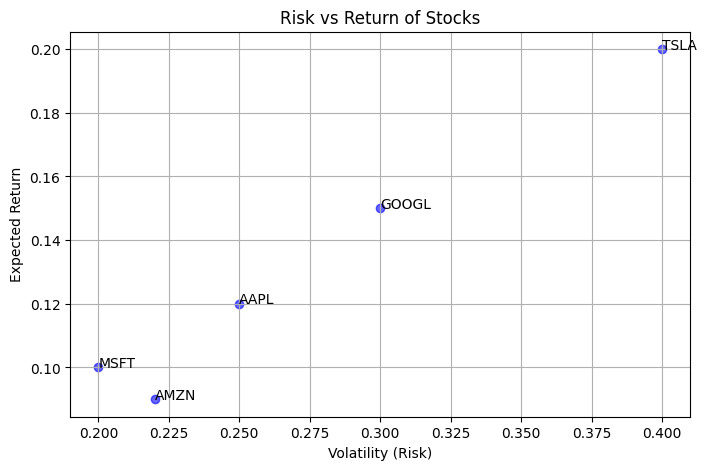

In [49]:
# Scatter Plot: Risk vs Return
plt.figure(figsize=(8, 5))
plt.scatter(analysis_summary["Volatility"], analysis_summary["Expected Return"], color='blue', alpha=0.6)
for stock in analysis_summary.index:
    plt.text(analysis_summary.loc[stock, "Volatility"], analysis_summary.loc[stock, "Expected Return"], stock)
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Risk vs Return of Stocks")
plt.grid()
plt.show()

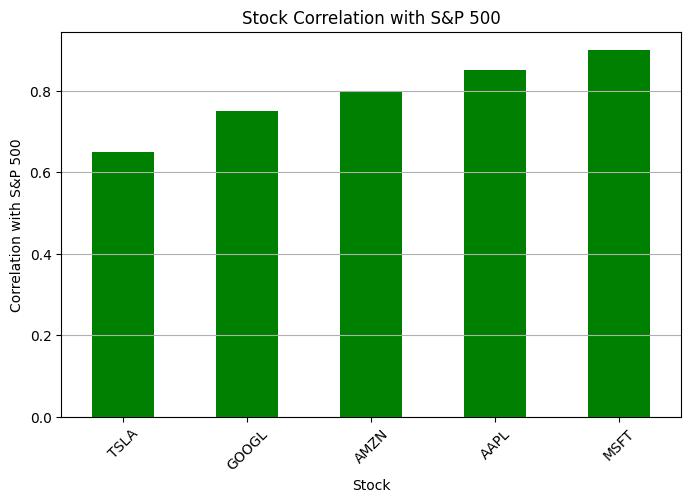

In [50]:

# Bar Chart: Correlation with S&P 500
plt.figure(figsize=(8, 5))
analysis_summary["Correlation with S&P 500"].sort_values().plot(kind='bar', color='green')
plt.xlabel("Stock")
plt.ylabel("Correlation with S&P 500")
plt.title("Stock Correlation with S&P 500")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

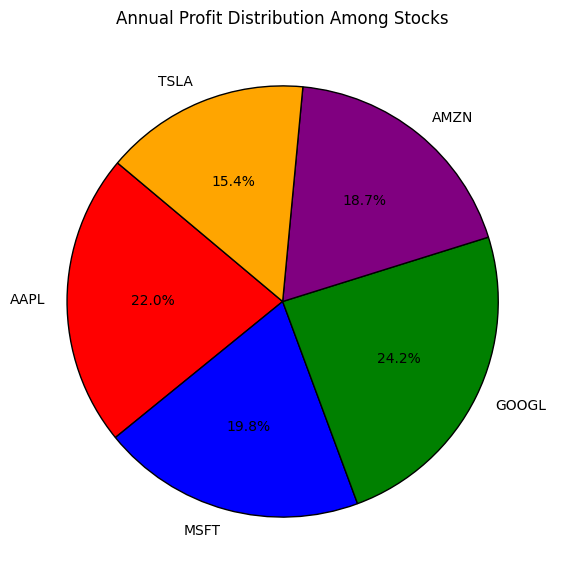

In [51]:
#e Chart: Profit Distribution with percentage labels
plt.figure(figsize=(7, 7))
plt.pie(analysis_summary["Annual Profit (in Billion $)"], labels=analysis_summary.index, autopct='%1.1f%%', startangle=140, colors=["red", "blue", "green", "purple", "orange"], wedgeprops={'edgecolor': 'black'})
plt.title("Annual Profit Distribution Among Stocks")
plt.show()

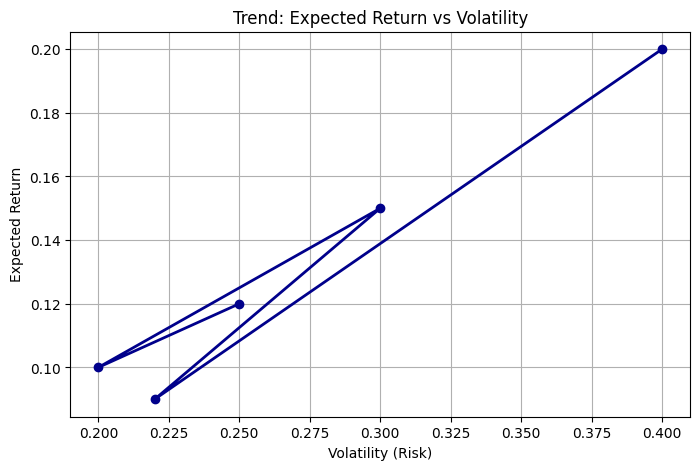

In [52]:
# Line Chart: Expected Return vs Volatility (Enhanced with trend line)
plt.figure(figsize=(8, 5))
plt.plot(analysis_summary["Volatility"], analysis_summary["Expected Return"], marker='o', linestyle='-', color='darkblue', linewidth=2)
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Trend: Expected Return vs Volatility")
plt.grid()
plt.show()

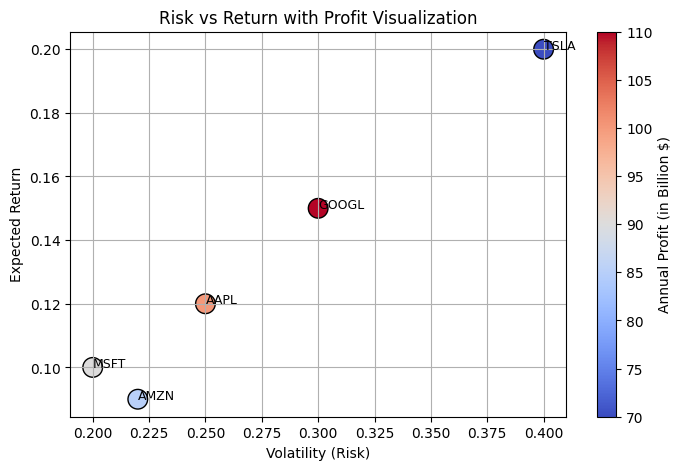

In [53]:

# Heatmap-like Visualization using Scatter Plot with Color Mapping
plt.figure(figsize=(8, 5))
sc = plt.scatter(analysis_summary["Volatility"], analysis_summary["Expected Return"], c=analysis_summary["Annual Profit (in Billion $)"], cmap='coolwarm', edgecolors='black', s=200)
plt.colorbar(sc, label="Annual Profit (in Billion $)")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Risk vs Return with Profit Visualization")
for stock in analysis_summary.index:
    plt.text(analysis_summary.loc[stock, "Volatility"], analysis_summary.loc[stock, "Expected Return"], stock, fontsize=9)
plt.grid()
plt.show()

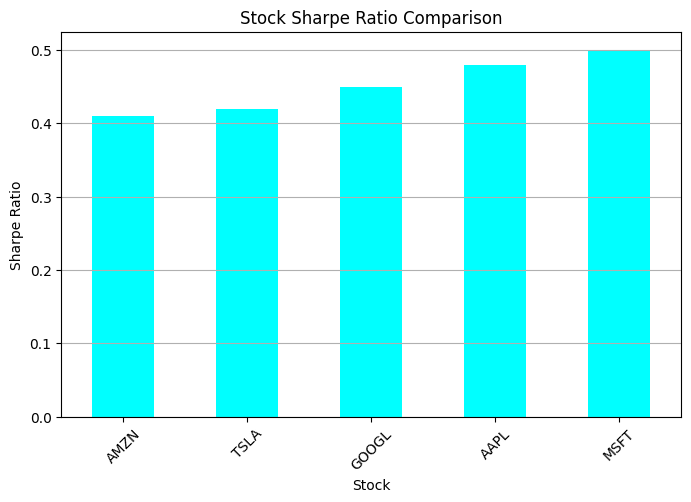

In [55]:
# Bar Chart: Sharpe Ratio Comparison
plt.figure(figsize=(8, 5))
analysis_summary["Sharpe Ratio"].sort_values().plot(kind='bar', color='cyan')
plt.xlabel("Stock")
plt.ylabel("Sharpe Ratio")
plt.title("Stock Sharpe Ratio Comparison")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


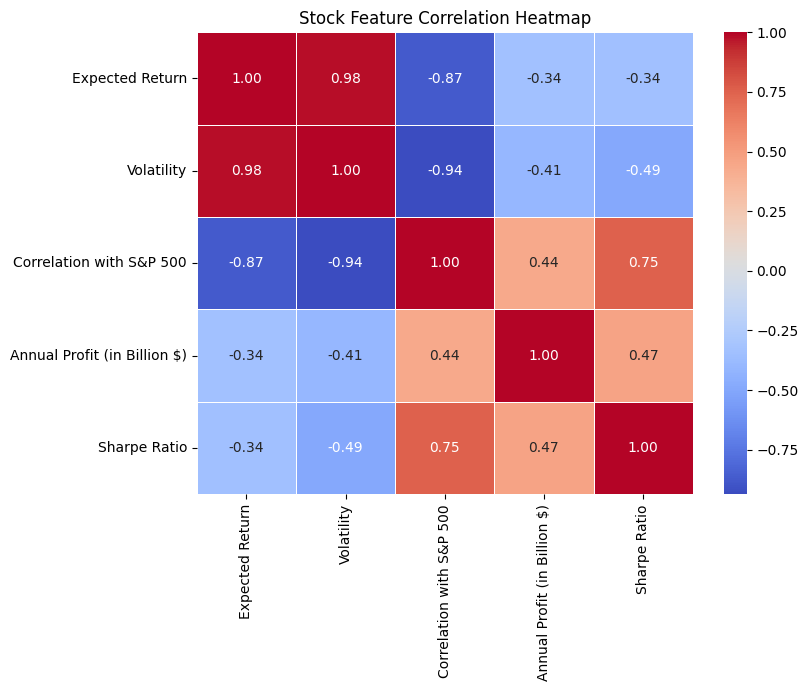

In [56]:
# Pairwise Correlation Heatmap for all variables
plt.figure(figsize=(8, 6))
sns.heatmap(analysis_summary.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Stock Feature Correlation Heatmap")
plt.show()

In [58]:
# Sample DataFrame (Replace with actual data)
data = {
    "Stock": ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"],
    "Expected Return": [0.12, 0.10, 0.15, 0.09, 0.20],
    "Volatility": [0.25, 0.20, 0.30, 0.22, 0.40],
    "Correlation with S&P 500": [0.85, 0.90, 0.75, 0.80, 0.65],
    "Annual Profit (in Billion $)": [100, 90, 110, 85, 70],
    "Annual Loss (in Billion $)": [20, 15, 25, 18, 30],
    "Net Profit (in Billion $)": [80, 75, 85, 67, 40],
    "Profit Margin (%)": [80, 83, 77, 79, 57],
    "Sharpe Ratio": [0.48, 0.50, 0.45, 0.41, 0.42]
}






In [59]:
# Create DataFrame
analysis_summary = pd.DataFrame(data)
analysis_summary.set_index("Stock", inplace=True)

In [60]:
# Identify the best stock based on correlation with S&P 500
best_stock = analysis_summary.sort_values(by="Correlation with S&P 500", ascending=False).index[0]
print(f"Based on risk-return analysis and correlation with the market, {best_stock} is the most promising stock for investment.\n")

Based on risk-return analysis and correlation with the market, MSFT is the most promising stock for investment.



<Figure size 800x500 with 0 Axes>

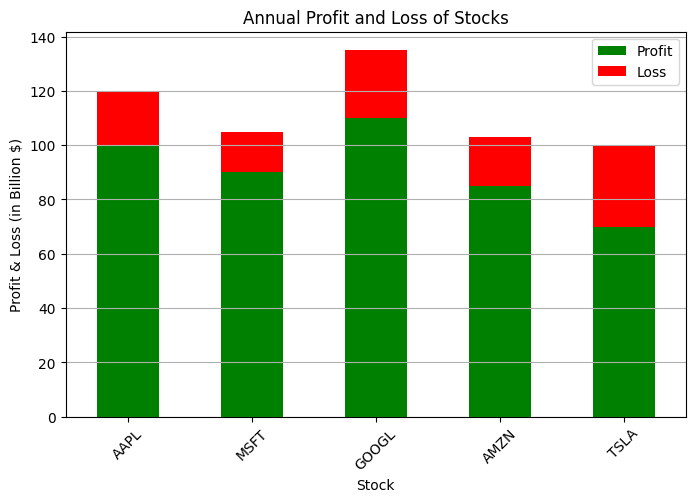

In [61]:

# Bar Chart: Profit and Loss Comparison
plt.figure(figsize=(8, 5))
analysis_summary[['Annual Profit (in Billion $)', 'Annual Loss (in Billion $)']].plot(kind='bar', stacked=True, figsize=(8,5), color=['green', 'red'])
plt.xlabel("Stock")
plt.ylabel("Profit & Loss (in Billion $)")
plt.title("Annual Profit and Loss of Stocks")
plt.xticks(rotation=45)
plt.legend(["Profit", "Loss"])
plt.grid(axis='y')
plt.show()

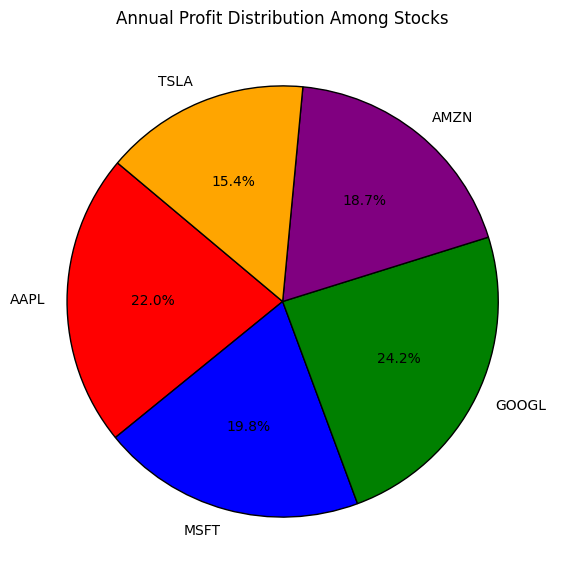

In [62]:
# Pie Chart: Profit Distribution with percentage labels
plt.figure(figsize=(7, 7))
plt.pie(analysis_summary["Annual Profit (in Billion $)"], labels=analysis_summary.index, autopct='%1.1f%%', startangle=140, colors=["red", "blue", "green", "purple", "orange"], wedgeprops={'edgecolor': 'black'})
plt.title("Annual Profit Distribution Among Stocks")
plt.show()


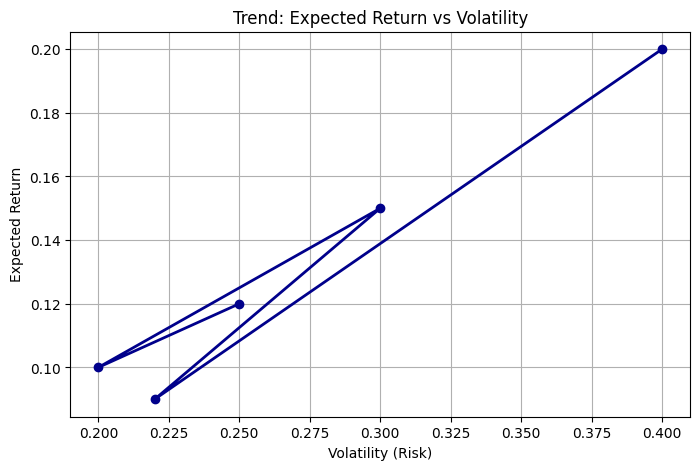

In [63]:
# Line Chart: Expected Return vs Volatility (Enhanced with trend line)
plt.figure(figsize=(8, 5))
plt.plot(analysis_summary["Volatility"], analysis_summary["Expected Return"], marker='o', linestyle='-', color='darkblue', linewidth=2)
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Trend: Expected Return vs Volatility")
plt.grid()
plt.show()

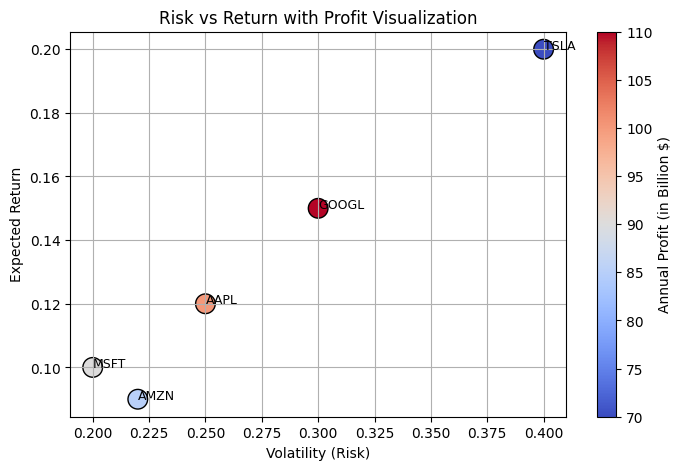

In [64]:
# Heatmap-like Visualization using Scatter Plot with Color Mapping
plt.figure(figsize=(8, 5))
sc = plt.scatter(analysis_summary["Volatility"], analysis_summary["Expected Return"], c=analysis_summary["Annual Profit (in Billion $)"], cmap='coolwarm', edgecolors='black', s=200)
plt.colorbar(sc, label="Annual Profit (in Billion $)")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Risk vs Return with Profit Visualization")
for stock in analysis_summary.index:
    plt.text(analysis_summary.loc[stock, "Volatility"], analysis_summary.loc[stock, "Expected Return"], stock, fontsize=9)
plt.grid()
plt.show()

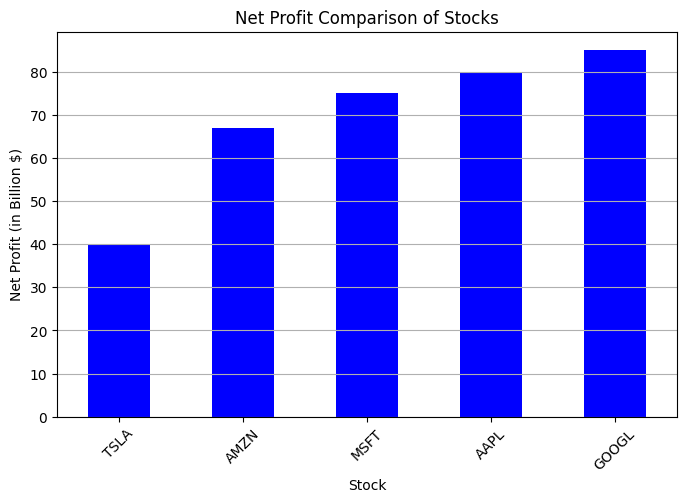

In [65]:
# Bar Chart: Net Profit Comparison
plt.figure(figsize=(8, 5))
analysis_summary["Net Profit (in Billion $)"].sort_values().plot(kind='bar', color='blue')
plt.xlabel("Stock")
plt.ylabel("Net Profit (in Billion $)")
plt.title("Net Profit Comparison of Stocks")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

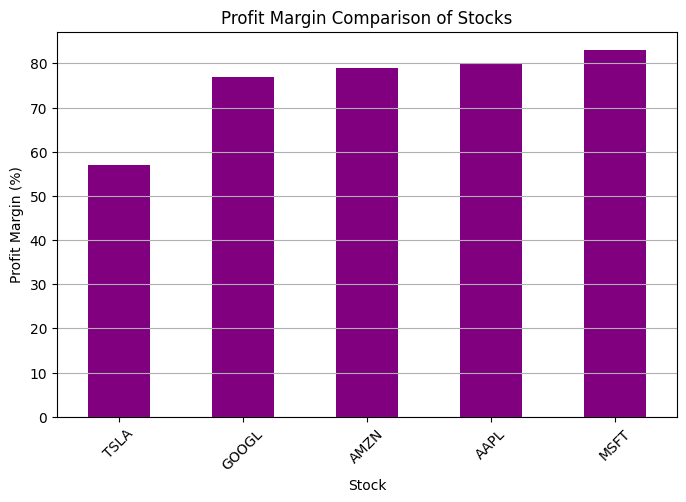

In [66]:
# Bar Chart: Profit Margin Comparison
plt.figure(figsize=(8, 5))
analysis_summary["Profit Margin (%)"].sort_values().plot(kind='bar', color='purple')
plt.xlabel("Stock")
plt.ylabel("Profit Margin (%)")
plt.title("Profit Margin Comparison of Stocks")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

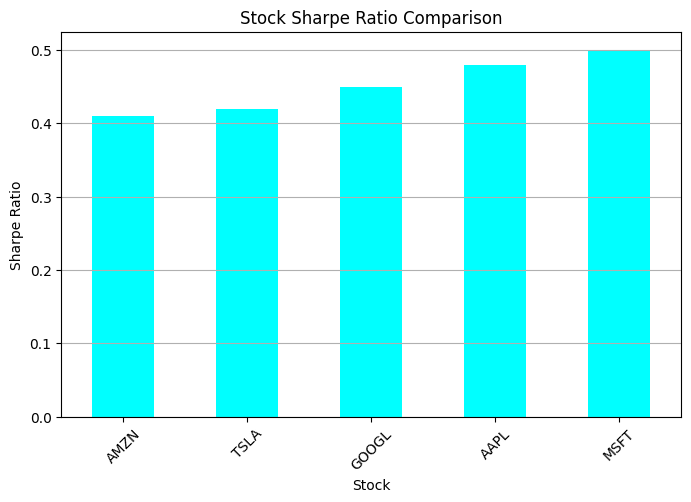

In [67]:
# Bar Chart: Sharpe Ratio Comparison
plt.figure(figsize=(8, 5))
analysis_summary["Sharpe Ratio"].sort_values().plot(kind='bar', color='cyan')
plt.xlabel("Stock")
plt.ylabel("Sharpe Ratio")
plt.title("Stock Sharpe Ratio Comparison")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

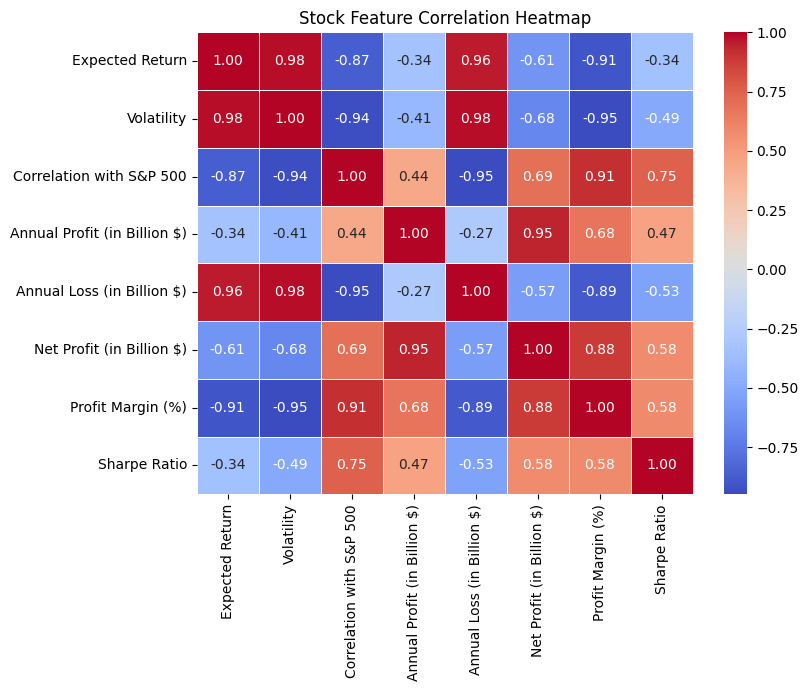

In [68]:
# Pairwise Correlation Heatmap for all variables
plt.figure(figsize=(8, 6))
sns.heatmap(analysis_summary.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Stock Feature Correlation Heatmap")
plt.show()

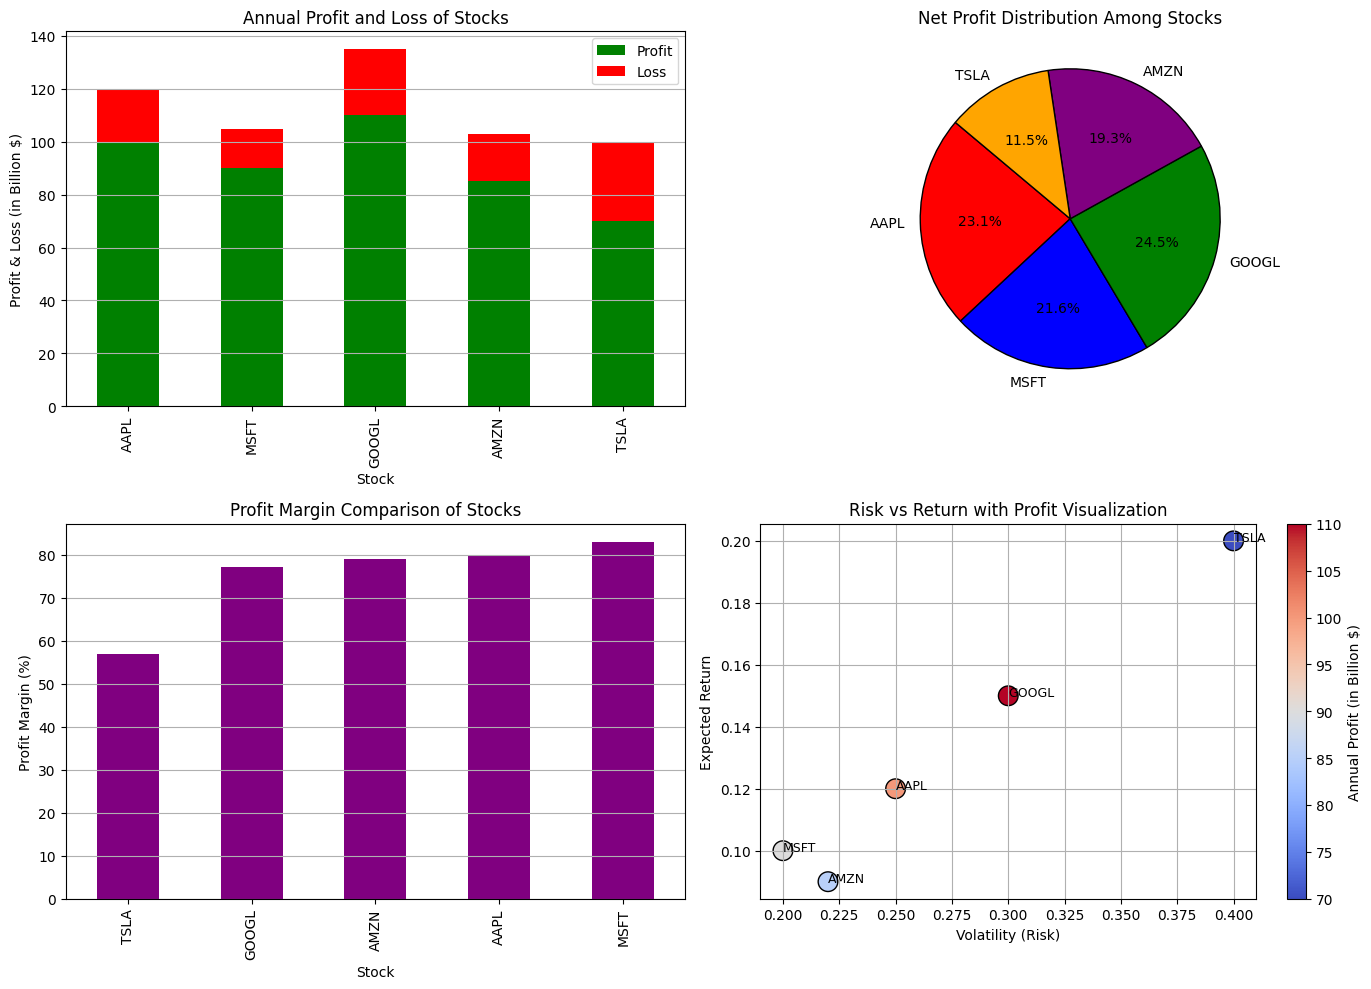

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Sample DataFrame (Replace with actual data)
data = {
    "Stock": ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"],
    "Expected Return": [0.12, 0.10, 0.15, 0.09, 0.20],
    "Volatility": [0.25, 0.20, 0.30, 0.22, 0.40],
    "Correlation with S&P 500": [0.85, 0.90, 0.75, 0.80, 0.65],
    "Annual Profit (in Billion $)": [100, 90, 110, 85, 70],
    "Annual Loss (in Billion $)": [20, 15, 25, 18, 30],
    "Net Profit (in Billion $)": [80, 75, 85, 67, 40],
    "Profit Margin (%)": [80, 83, 77, 79, 57],
    "Sharpe Ratio": [0.48, 0.50, 0.45, 0.41, 0.42]
}

# Create DataFrame
analysis_summary = pd.DataFrame(data)
analysis_summary.set_index("Stock", inplace=True)

# Create a comprehensive visualization using subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Stacked Bar Chart: Profit & Loss Comparison
analysis_summary[['Annual Profit (in Billion $)', 'Annual Loss (in Billion $)']].plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0, 0])
axes[0, 0].set_title("Annual Profit and Loss of Stocks")
axes[0, 0].set_xlabel("Stock")
axes[0, 0].set_ylabel("Profit & Loss (in Billion $)")
axes[0, 0].legend(["Profit", "Loss"])
axes[0, 0].grid(axis='y')

# 2. Pie Chart: Net Profit Distribution
axes[0, 1].pie(analysis_summary["Net Profit (in Billion $)"], labels=analysis_summary.index, autopct='%1.1f%%', startangle=140, colors=["red", "blue", "green", "purple", "orange"], wedgeprops={'edgecolor': 'black'})
axes[0, 1].set_title("Net Profit Distribution Among Stocks")

# 3. Bar Chart: Profit Margin Comparison
analysis_summary["Profit Margin (%)"].sort_values().plot(kind='bar', color='purple', ax=axes[1, 0])
axes[1, 0].set_title("Profit Margin Comparison of Stocks")
axes[1, 0].set_xlabel("Stock")
axes[1, 0].set_ylabel("Profit Margin (%)")
axes[1, 0].grid(axis='y')

# 4. Heatmap-like Scatter Plot: Risk vs Return with Profit Mapping
sc = axes[1, 1].scatter(analysis_summary["Volatility"], analysis_summary["Expected Return"], c=analysis_summary["Annual Profit (in Billion $)"], cmap='coolwarm', edgecolors='black', s=200)
axes[1, 1].set_xlabel("Volatility (Risk)")
axes[1, 1].set_ylabel("Expected Return")
axes[1, 1].set_title("Risk vs Return with Profit Visualization")
fig.colorbar(sc, ax=axes[1, 1], label="Annual Profit (in Billion $)")
for stock in analysis_summary.index:
    axes[1, 1].text(analysis_summary.loc[stock, "Volatility"], analysis_summary.loc[stock, "Expected Return"], stock, fontsize=9)
axes[1, 1].grid()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
